In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.decomposition import PCA
from sklearn.compose import ColumnTransformer
from imblearn.over_sampling import SMOTE
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import seaborn as sns

In [2]:
data = pd.read_csv("Preprocessed_Data.csv")
df = pd.DataFrame(data)

In [3]:
df.drop(['CRSDepTime', 'DepDel15', 'ArrTime', 'CRSArrTime', 'OriginAirportID', 'DestAirportID', 'Quarter'
         , 'FlightDate', 'WindGustKmph', 'WindChillF'], axis = 1, inplace = True)

In [4]:
df.to_csv("Preprocessed_Data_Regression.csv", index=False)

In [5]:
data = pd.read_csv("Preprocessed_Data_Regression.csv")
df = pd.DataFrame(data)

In [6]:
df.head()

,Year,Month,DayofMonth,Origin,Dest,DepTime,DepDelayMinutes,ArrDelayMinutes,ArrDel15,rounded_time,WindSpeedKmph,WindDirDegree,WeatherCode,precipMM,Visibility,Pressure,Cloudcover,DewPointF,tempF,Humidity
0,2016,1,1,SEA,JFK,741.0,0.0,8,0.0,1600,22.0,255.0,113.0,0.0,10.0,1015.0,0.0,32.0,41.0,74.0
1,2016,1,2,SEA,JFK,737.0,0.0,11,0.0,1600,19.0,248.0,113.0,0.0,10.0,1016.0,0.0,30.0,39.0,71.0
2,2016,1,3,SEA,JFK,743.0,0.0,0,0.0,1600,23.0,272.0,113.0,0.0,10.0,1009.0,46.0,31.0,40.0,69.0
3,2016,1,4,SEA,JFK,737.0,0.0,0,0.0,1600,28.0,342.0,116.0,0.0,10.0,1019.0,22.0,15.0,26.0,65.0
4,2016,1,5,SEA,JFK,708.0,0.0,0,0.0,1500,17.0,337.0,113.0,0.0,10.0,1035.0,0.0,14.0,27.0,61.0


In [7]:
df.shape

(1851436, 20)

In [8]:
categorical_cols = df.select_dtypes(include=['object']).columns
numerical_cols = df.select_dtypes(include=['int64', 'float64']).columns

categorical_transformer = OneHotEncoder(handle_unknown='ignore')
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', categorical_transformer, categorical_cols)
    ],
    remainder='passthrough' 
)

df_transformed = preprocessor.fit_transform(df)

encoded_cat_cols = preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_cols)
all_cols = list(encoded_cat_cols) + list(numerical_cols)
df_transformed = pd.DataFrame(df_transformed, columns=all_cols)

train_df, test_df = train_test_split(df_transformed, test_size=0.25, random_state=0)

smote = SMOTE(random_state=0)
X_train_smote, y_train_smote = smote.fit_resample(
    train_df.drop(columns=['ArrDel15']), 
    train_df['ArrDel15']
)
X_test_smote, y_test_smote = smote.fit_resample(
    test_df.drop(columns=['ArrDel15']), 
    test_df['ArrDel15']
)

X_train = pd.DataFrame(X_train_smote, columns=train_df.drop(columns=['ArrDel15']).columns)
X_train['ArrDel15'] = y_train_smote

X_test = pd.DataFrame(X_test_smote, columns=test_df.drop(columns=['ArrDel15']).columns)
X_test['ArrDel15'] = y_test_smote

y_train = X_train.pop('ArrDelayMinutes')
y_test = X_test.pop('ArrDelayMinutes')

X_train.drop(columns=['ArrDel15'], inplace=True)
X_test.drop(columns=['ArrDel15'], inplace=True)

X_train.to_csv('X_train_res_regression.csv', index=False)
y_train.to_csv('y_train_res_regression.csv', index=False)
X_test.to_csv('X_test_res_regression.csv', index=False)
y_test.to_csv('y_test_res_regression.csv', index=False)

In [9]:
model = LinearRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

print("Linear Regression Performance:")
print(f"Mean Squared Error: {mse:.4f}")
print(f"R^2 Score: {r2:.4f}")
print(f"Mean Absolute Error: {mae:.4f}")

Linear Regression Performance:
Mean Squared Error: 183.2363
R^2 Score: 0.9477
Mean Absolute Error: 8.8139


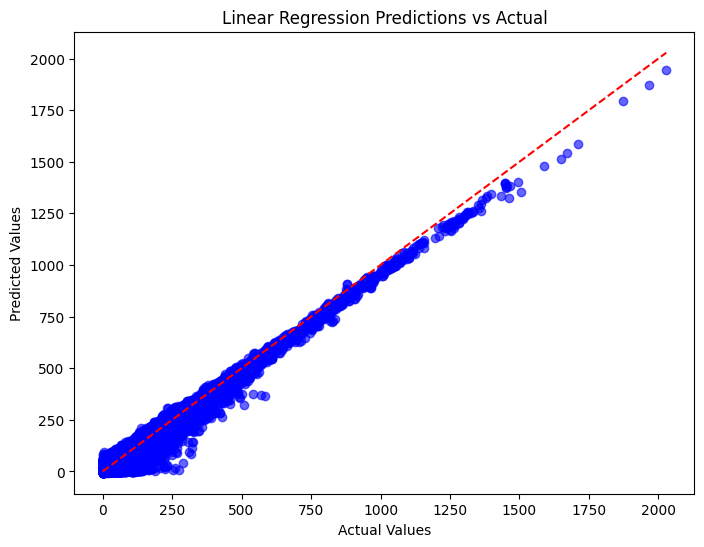

In [10]:
def visualize_results(y_test, y_pred, model_name):
    plt.figure(figsize=(8, 6))
    plt.scatter(y_test, y_pred, color='blue', alpha=0.6)
    plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--')
    plt.title(f'{model_name} Predictions vs Actual')
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')
    plt.show()

visualize_results(y_test, y_pred, 'Linear Regression')